<a href="https://colab.research.google.com/github/mathchou/CSC485-Sp24/blob/egelchie/phishingproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn as sk
import matplotlib
import tensorflow as tf
import pandas as pd
import csv as csv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ph = pd.read_csv('/content/dataset_link_phishing.csv')
print(ph)

       Unnamed: 0                                                url  \
0               0     http://www.progarchives.com/album.asp?id=61737   
1               1  http://signin.eday.co.uk.ws.edayisapi.dllsign....   
2               2  http://www.avevaconstruction.com/blesstool/ima...   
3               3                              http://www.jp519.com/   
4               4                       https://www.velocidrone.com/   
...           ...                                                ...   
19426       11425      http://www.fontspace.com/category/blackletter   
19427       11426  http://www.budgetbots.com/server.php/Server%20...   
19428       11427  https://www.facebook.com/Interactive-Televisio...   
19429       11428             http://www.mypublicdomainpictures.com/   
19430       11429  http://174.139.46.123/ap/signin?openid.pape.ma...   

       url_length  hostname_length  ip  total_of.  total_of-  total_of@  \
0              46               20   0          3          0

<ipython-input-2-c1f1b7a20059>:1: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  ph = pd.read_csv('/content/dataset_link_phishing.csv')


In [ ]:
ph.columns

Index(['Unnamed: 0', 'url', 'url_length', 'hostname_length', 'ip', 'total_of.',
       'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
       'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*',
       'total_of:', 'total_of,', 'total_of;', 'total_of$', 'total_of_www',
       'total_of_com', 'total_of_http_in_path', 'https_token',
       'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port',
       'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain',
       'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statist

In [ ]:
ph.head()

,Unnamed: 0,url,url_length,hostname_length,ip,total_of.,total_of-,total_of@,total_of?,total_of&,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,0,http://www.progarchives.com/album.asp?id=61737,46,20,0,3,0,0,1,0,...,1,one,0,627,6678,78526,0,0,5,phishing
1,1,http://signin.eday.co.uk.ws.edayisapi.dllsign....,128,120,0,10,0,0,0,0,...,1,zero,0,300,65,0,0,1,0,phishing
2,2,http://www.avevaconstruction.com/blesstool/ima...,52,25,0,3,0,0,0,0,...,1,zero,0,119,1707,0,0,1,0,phishing
3,3,http://www.jp519.com/,21,13,0,2,0,0,0,0,...,1,one,0,130,1331,0,0,0,0,legitimate
4,4,https://www.velocidrone.com/,28,19,0,2,0,0,0,0,...,0,zero,0,164,1662,312044,0,0,4,legitimate


In [ ]:
# Checking for missing values
missing_values = ph.isnull().sum()

# Filtering out columns that have missing values
missing_values[missing_values > 0]


Series([], dtype: int64)

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Initialize the label encoder for categorical data transformation
label_encoder = LabelEncoder()

# Encode the 'status' column to transform categories into numbers
# This is necessary because machine learning models require numerical input.
# Here, 'phishing' and 'legitimate' statuses in the dataset are converted to numeric values.
ph['status_encoded'] = label_encoder.fit_transform(ph['status'])

# Initialize the Min-Max Scaler for numerical data normalization
min_max_scaler = MinMaxScaler()

# Select numerical features that will be normalized
# Normalization adjusts the scale of numerical features so each feature contributes equally to model training.
# It prevents features with larger values from disproportionately influencing the model.
numerical_features = ['url_length', 'web_traffic']

# Apply Min-Max Scaling to normalize the selected features to a range between 0 and 1.
# The formula used for Min-Max Scaling is (X - X_min) / (X_max - X_min).
# This is crucial for distance-based algorithms and helps in faster convergence of gradient descent-based algorithms.
ph[numerical_features] = min_max_scaler.fit_transform(ph[numerical_features])

# Display the first few rows to verify the changes
# The 'status_encoded' column now contains numeric representations of the original 'status' text values.
# The 'url_length' and 'web_traffic' features have been scaled to a range between 0 and 1.
ph[['status', 'status_encoded', 'url_length', 'web_traffic']].head()


,status,status_encoded,url_length,web_traffic
0,phishing,1,0.020872,0.007293
1,phishing,1,0.071209,0.000000
2,phishing,1,0.024555,0.000000
3,legitimate,0,0.005525,0.000000
4,legitimate,0,0.009822,0.028979


In [ ]:
# Identifying outliers using the IQR method for 'url_length' and 'web_traffic'

# Calculate IQR for 'url_length'
Q1_url_length = ph['url_length'].quantile(0.25)
Q3_url_length = ph['url_length'].quantile(0.75)
IQR_url_length = Q3_url_length - Q1_url_length

# Calculate the bounds for outliers
lower_bound_url_length = Q1_url_length - 1.5 * IQR_url_length
upper_bound_url_length = Q3_url_length + 1.5 * IQR_url_length

# Calculate IQR for 'web_traffic'
Q1_web_traffic = ph['web_traffic'].quantile(0.25)
Q3_web_traffic = ph['web_traffic'].quantile(0.75)
IQR_web_traffic = Q3_web_traffic - Q1_web_traffic

# Calculate the bounds for outliers
lower_bound_web_traffic = Q1_web_traffic - 1.5 * IQR_web_traffic
upper_bound_web_traffic = Q3_web_traffic + 1.5 * IQR_web_traffic

# Determine the number of outliers
outliers_url_length = ph[(ph['url_length'] < lower_bound_url_length) | (ph['url_length'] > upper_bound_url_length)]
outliers_web_traffic = ph[(ph['web_traffic'] < lower_bound_web_traffic) | (ph['web_traffic'] > upper_bound_web_traffic)]

# Check for inconsistencies in 'status' column
status_values = ph['status'].unique()

(outliers_url_length.shape[0], outliers_web_traffic.shape[0], status_values)


(1051, 3648, array(['phishing', 'legitimate'], dtype=object))

In [ ]:
ph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19431 entries, 0 to 19430
Data columns (total 88 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  19431 non-null  int64  
 1   url                         19431 non-null  object 
 2   url_length                  19431 non-null  float64
 3   hostname_length             19431 non-null  int64  
 4   ip                          19431 non-null  int64  
 5   total_of.                   19431 non-null  int64  
 6   total_of-                   19431 non-null  int64  
 7   total_of@                   19431 non-null  int64  
 8   total_of?                   19431 non-null  int64  
 9   total_of&                   19431 non-null  int64  
 10  total_of=                   19431 non-null  int64  
 11  total_of_                   19431 non-null  int64  
 12  total_of~                   19431 non-null  int64  
 13  total_of%                   194

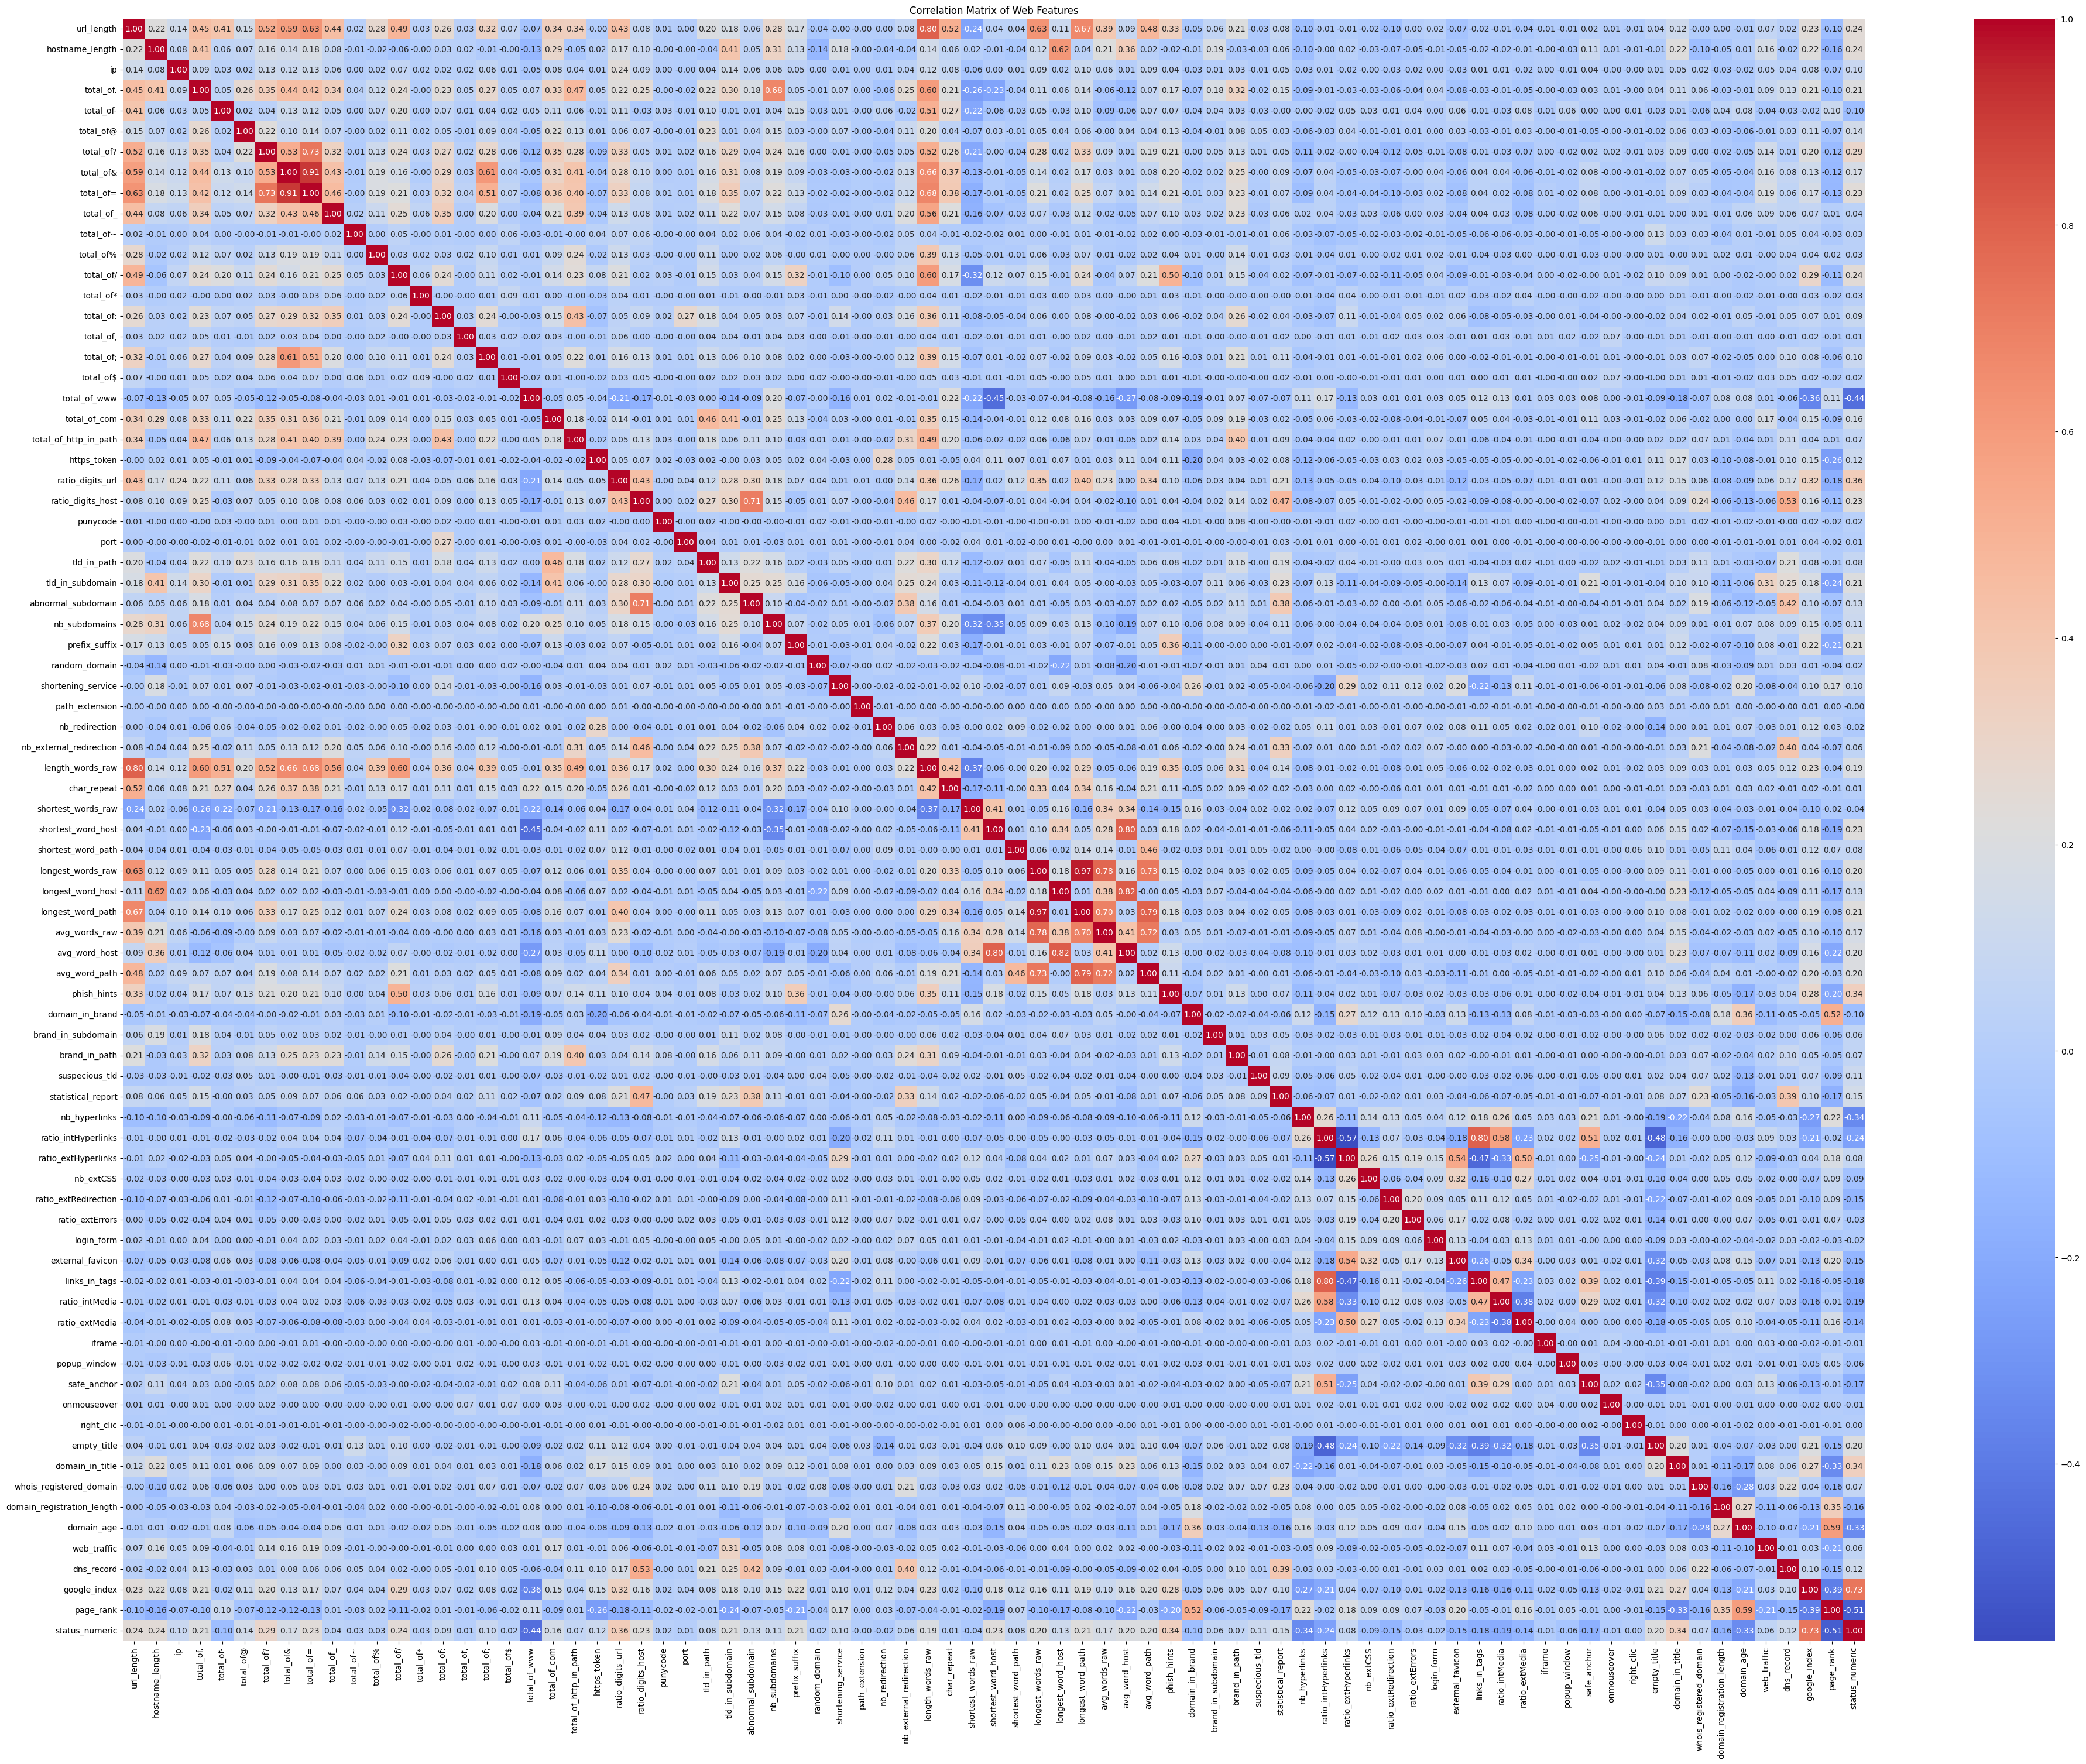

In [ ]:
# Correlation matrix for a subset of the dataset
# Selecting a subset of columns for the correlation analysis to keep it interpretable
columns_for_correlation = [
     'url_length', 'hostname_length', 'ip', 'total_of.',
       'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
       'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*',
       'total_of:', 'total_of,', 'total_of;', 'total_of$', 'total_of_www',
       'total_of_com', 'total_of_http_in_path', 'https_token',
       'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port',
       'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain',
       'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 'nb_hyperlinks', 'ratio_intHyperlinks',
       'ratio_extHyperlinks', 'nb_extCSS', 'ratio_extRedirection',
       'ratio_extErrors', 'login_form', 'external_favicon', 'links_in_tags',
       'ratio_intMedia', 'ratio_extMedia', 'iframe',
       'popup_window', 'safe_anchor', 'onmouseover', 'right_clic',
       'empty_title', 'domain_in_title', 'whois_registered_domain',
        'domain_registration_length', 'domain_age',
       'web_traffic', 'dns_record', 'google_index', 'page_rank',
]

# Adding the 'status' column by mapping 'phishing' to 1 and 'legitimate' to 0
ph['status_numeric'] = ph['status'].map({'phishing': 1, 'legitimate': 0})

# Including the 'status_numeric' column to see how other features correlate with the website being phishing or legitimate
columns_for_correlation.append('status_numeric')

# Calculating the correlation matrix
correlation_matrix = ph[columns_for_correlation].corr()

# Plotting the correlation matrix
plt.figure(figsize=(48, 36))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Web Features')
plt.show()




```
# Heatmap with Prioritized Variables
```



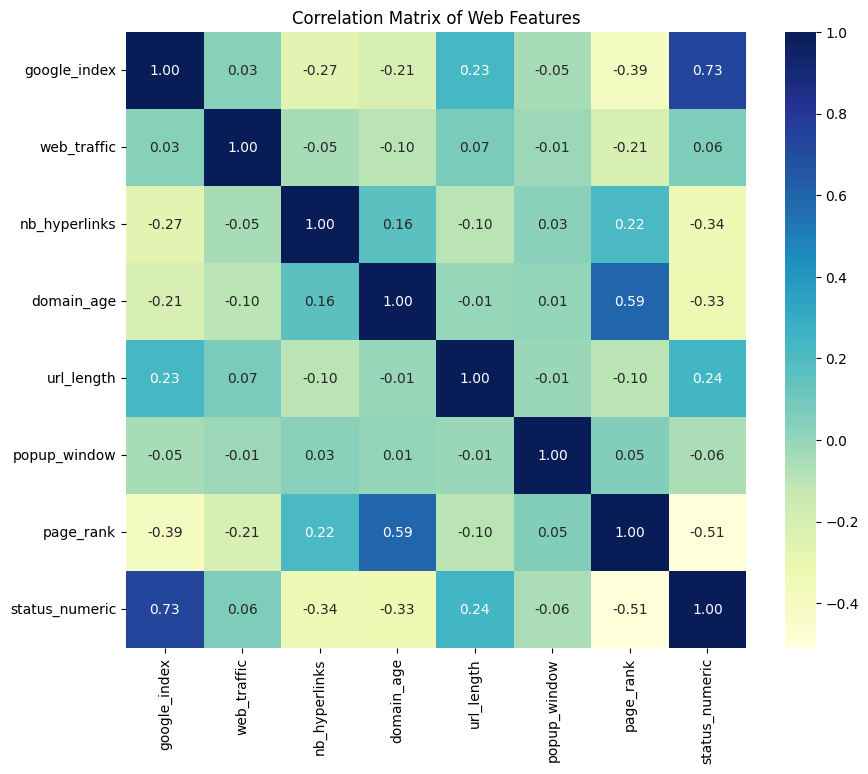

In [ ]:
pri_Columns = [
     'google_index', 'web_traffic', 'nb_hyperlinks', 'domain_age', 'url_length', 'popup_window', 'page_rank'
]

# Adding phishing status with Binary Variable
ph['status_numeric'] = ph['status'].map({'phishing': 1, 'legitimate': 0})
pri_Columns.append('status_numeric')

# Building
correlation_matrix = ph[pri_Columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix of Web Features')
plt.show()


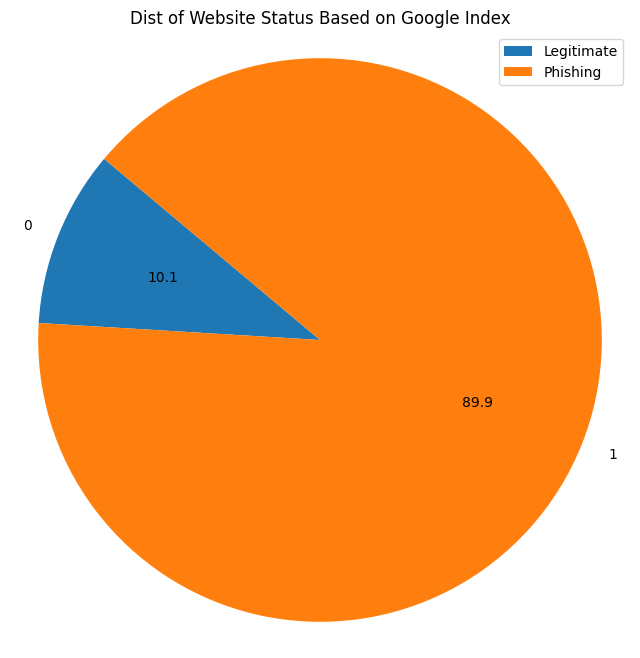

In [ ]:
pdf = pd.DataFrame(ph)

status_counts = pdf.groupby('google_index')['status_numeric'].value_counts()

pdf_pie_data = status_counts.unstack()

plt.figure(figsize=(8, 8))
plt.pie(pdf_pie_data[1], labels=pdf_pie_data.index, autopct='%1.1f', startangle=140)
plt.axis('equal')
plt.legend(['Legitimate', 'Phishing'], loc='best')
plt.title('Dist of Website Status Based on Google Index')
plt.show()

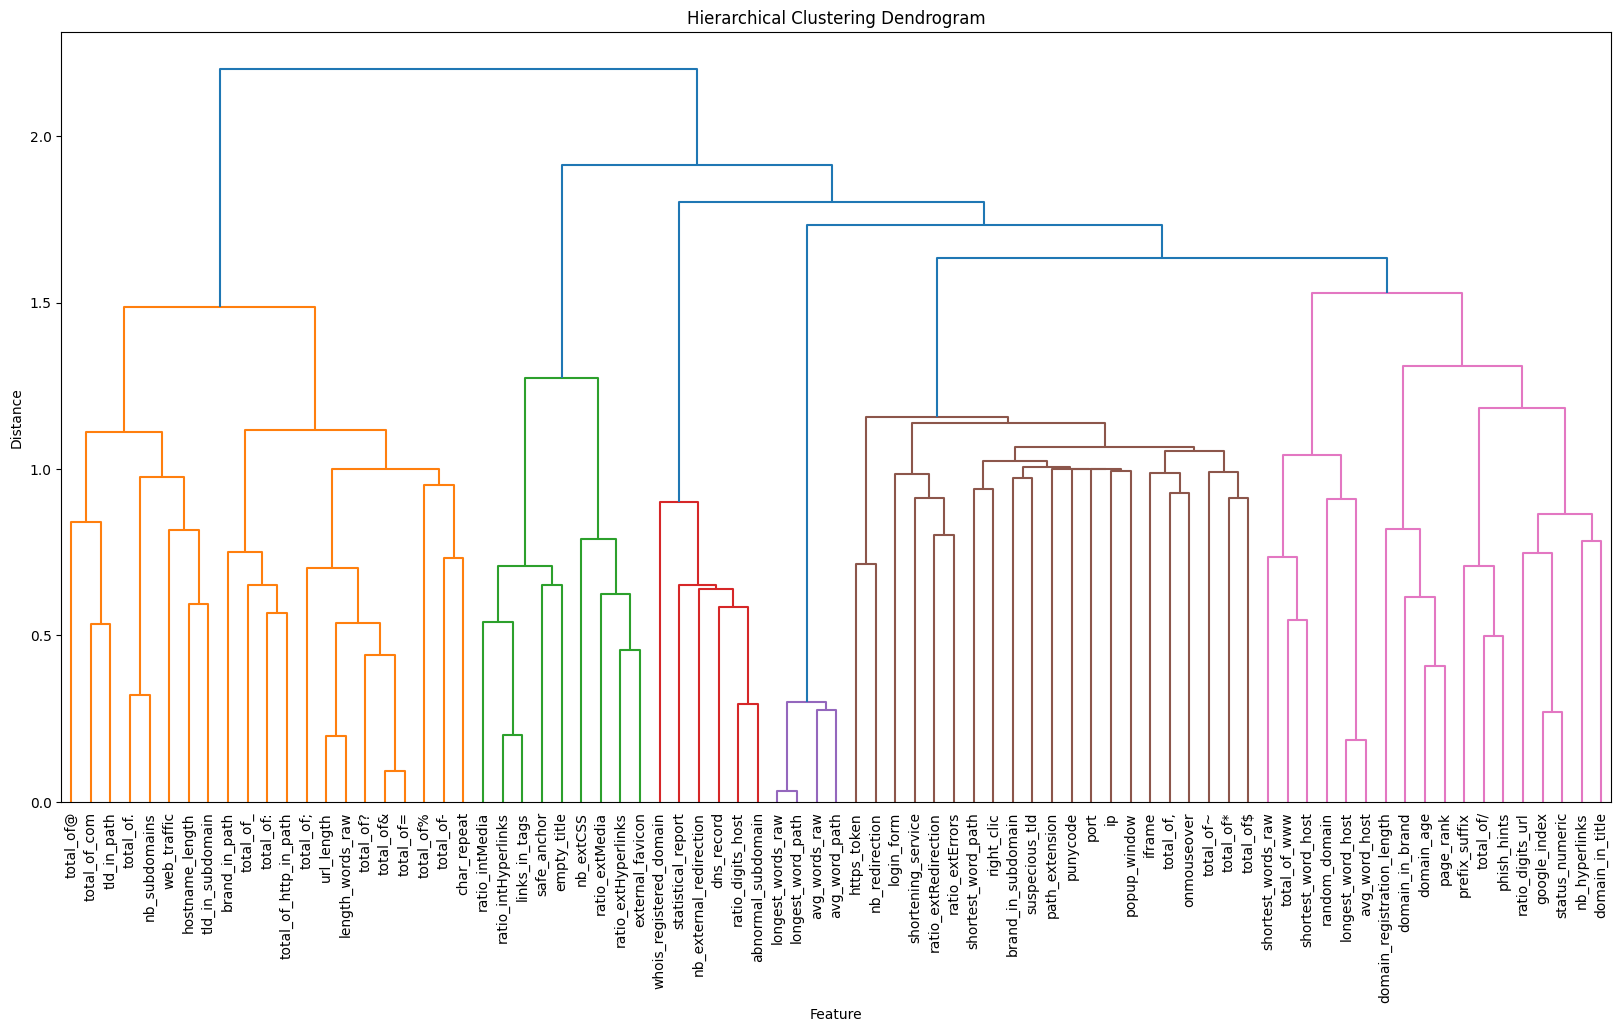

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform


# Calculate the correlation matrix for the selected features
correlation_matrix = ph[columns_for_correlation].corr()
# The correlation matrix measures the linear relationships between the variables.
# A correlation coefficient close to 1 means a strong positive correlation: as one variable increases, the other tends to also increase.
# A coefficient close to -1 means a strong negative correlation: as one variable increases, the other tends to decrease.
# Coefficients near 0 indicate a weak or no linear relationship.

# Convert the correlation matrix to a distance matrix suitable for hierarchical clustering
distance_matrix = 1 - np.abs(correlation_matrix)
# Distance matrix transformation is crucial as hierarchical clustering doesn't work with similarity measures directly.
# We use the absolute value of the correlation matrix to treat negative and positive correlations equally,
# then subtract from 1 to invert the scale: 0 (no distance, perfect correlation) to 1 (maximum distance, no correlation).

# Perform hierarchical clustering using the Ward method
linkage = hierarchy.ward(squareform(distance_matrix))
# Ward's method minimizes the total within-cluster variance. At each step, it finds the pair of clusters that leads
# to a minimum increase in total within-cluster variance after merging.
# This method is often more robust to different shapes and sizes of data clusters.

# Plot the dendrogram for visual analysis
plt.figure(figsize=(20, 10))
dendrogram = hierarchy.dendrogram(linkage, labels=correlation_matrix.columns, leaf_rotation=90, leaf_font_size=10)
# The dendrogram is a tree-like diagram that records the sequences of merges or splits.
# The leaves represent individual features and their arrangement shows the groups of features that are similar to each other.
# The height of the branches reflects the distance or dissimilarity between feature clusters.

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.show()
# The 'Distance' on the y-axis represents the dissimilarity level. Higher values indicate less similarity between clusters.
# Reading the dendrogram from the top down, you can see the point where any two clusters are combined into a new cluster,
# providing insight into the structure of data feature relationships.

# Google Index//Page Rank

<ipython-input-13-efb58acec5d8>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='google_index', y='status_numeric', data=ph, ci=None)


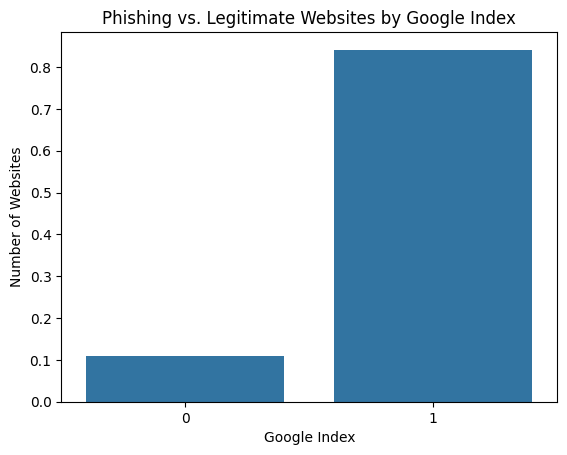

In [ ]:


# Create a bar chart with separate bars for phishing and legitimate websites based on the 'google_index' variable
sns.barplot(x='google_index', y='status_numeric', data=ph, ci=None)
plt.title('Phishing vs. Legitimate Websites by Google Index')
plt.xlabel('Google Index')
plt.ylabel('Number of Websites')
plt.show()


# More Distribution Plots

In [ ]:
nZ = pd.DataFrame(ph)

# Filter out zero values for a specific column
wt = 'web_traffic'
filtered_df = nZ[nZ[wt] != 0]

print("Filtered DataFrame:")
print(filtered_df)

Filtered DataFrame:
       Unnamed: 0                                                url  \
0               0     http://www.progarchives.com/album.asp?id=61737   
4               4                       https://www.velocidrone.com/   
5               5  https://support-appleld.com.secureupdate.duila...   
6               6  https://www.authpro.com/auth/ubabankng/?action...   
8               8                http://www.tutorialspoint.com/dbms/   
...           ...                                                ...   
19424       11423  http://www.dmega.co.kr/dmega/data/qna/sec/page...   
19425       11424  http://www.answers.com/Q/What_are_the_sizes_of...   
19426       11425      http://www.fontspace.com/category/blackletter   
19428       11427  https://www.facebook.com/Interactive-Televisio...   
19429       11428             http://www.mypublicdomainpictures.com/   

       url_length  hostname_length  ip  total_of.  total_of-  total_of@  \
0        0.020872               20   0  

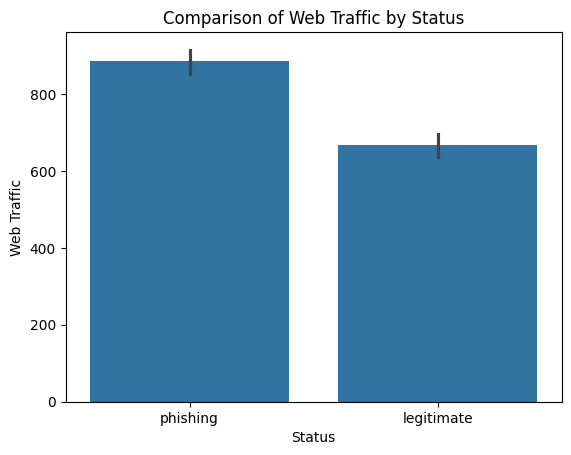

In [ ]:
sns.barplot(x='status', y='web_traffic', data=filtered_df, estimator=sum)  # Use estimator='mean' for mean instead of sum
plt.title('Comparison of Web Traffic by Status')
plt.xlabel('Status')
plt.ylabel('Web Traffic')
plt.show()

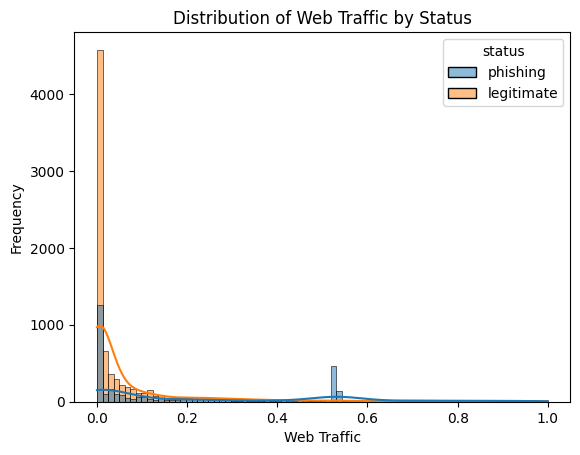

In [ ]:
sns.histplot(data=filtered_df, x='web_traffic', hue='status', kde=True)
plt.title('Distribution of Web Traffic by Status')
plt.xlabel('Web Traffic')
plt.ylabel('Frequency')
plt.show()

In [ ]:
webtrafficmean = np.mean(ph[wt])
print("Mean: ", webtrafficmean)

Mean:  0.0798208324423665


In [ ]:
mean_traffic_by_status = ph.groupby('status')['web_traffic'].mean()

print("Mean web traffic by status:")
print(mean_traffic_by_status)


Mean web traffic by status:
status
legitimate    0.068589
phishing      0.091054
Name: web_traffic, dtype: float64


In [ ]:
ph['keyword_login'] = ph['url'].apply(lambda x: 1 if 'login' in x.lower() else 0)


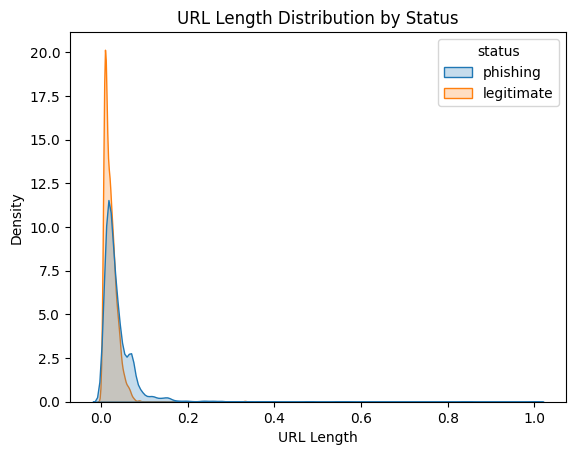

In [ ]:

sns.kdeplot(data=ph, x='url_length', hue='status', fill=True)
plt.title('URL Length Distribution by Status')
plt.xlabel('URL Length')
plt.ylabel('Density')
plt.show()


In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

# Cross-tabulation
cross_tab = pd.crosstab(ph['google_index'], ph['status'])
print(cross_tab)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(cross_tab)
print(f'Chi-square test p-value: {p}')
#the null hypothesis is rejected, test is statistically significant

status        legitimate  phishing
google_index                      
0                   8069       986
1                   1647      8729
Chi-square test p-value: 0.0


In [ ]:
from scipy.stats import ttest_ind

# Splitting the dataset
phishing = ph[ph['status'] == 'phishing']['url_length']
legitimate = ph[ph['status'] == 'legitimate']['url_length']

# Performing the T-test
t_stat, p_val = ttest_ind(phishing, legitimate)
print(f'T-test p-value: {p_val}')
#the url_length of phishing vs. legitimate sites is highly statistically significant.



T-test p-value: 4.3510105854835096e-262


In [ ]:
from sklearn.model_selection import train_test_split
# Prepare the features and target variable
X = ph.drop(['status', 'status_encoded'], axis=1)  # Dropping non-feature columns
y = ph['status_encoded']  # Target variable

# Split the dataset into training and testing sets
# test_size=0.2 indicates that 20% of the data will be used for testing
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Ranking Importance of Variables
Contributing to websites being either Phishing or Legittimate


**Gradient Boosting**

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt


In [ ]:
model = xgb.XGBClassifier()

X_train.dtypes

Unnamed: 0           int64
url                 object
url_length         float64
hostname_length      int64
ip                   int64
                    ...   
dns_record           int64
google_index         int64
page_rank            int64
status_numeric       int64
keyword_login        int64
Length: 88, dtype: object

In [ ]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:

# Define the XGBoost model
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
print(y_train.unique())

[0 1]


In [ ]:
y_train = y_train.replace({'legitimate': 0, 'phishing': 1})

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

<ipython-input-32-b9c1dc6215f2>:8: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  phishing_data = pd.read_csv(file_path)


NaNs per column after coercion: Unnamed: 0         0
url_length         0
hostname_length    0
ip                 0
total_of.          0
                  ..
domain_age         0
web_traffic        0
dns_record         0
google_index       0
page_rank          0
Length: 85, dtype: int64
Columns dropped (zero variance): ['ratio_nullHyperlinks', 'ratio_intRedirection', 'ratio_intErrors', 'submit_email', 'sfh']
Remaining features: 80
Top feature importances: [('google_index', 0.5366645), ('total_of_www', 0.034909975), ('page_rank', 0.032817166), ('total_of?', 0.031655744), ('nb_hyperlinks', 0.026839303), ('ratio_digits_host', 0.02229879), ('phish_hints', 0.02168303), ('suspecious_tld', 0.019891333), ('total_of:', 0.01880727), ('total_of_http_in_path', 0.015125664), ('domain_in_brand', 0.014275822), ('total_of=', 0.011253371), ('total_of-', 0.009464157), ('web_traffic', 0.0094039105), ('length_words_raw', 0.009289093), ('shortest_word_path', 0.008952187), ('shortening_service', 0.008385519

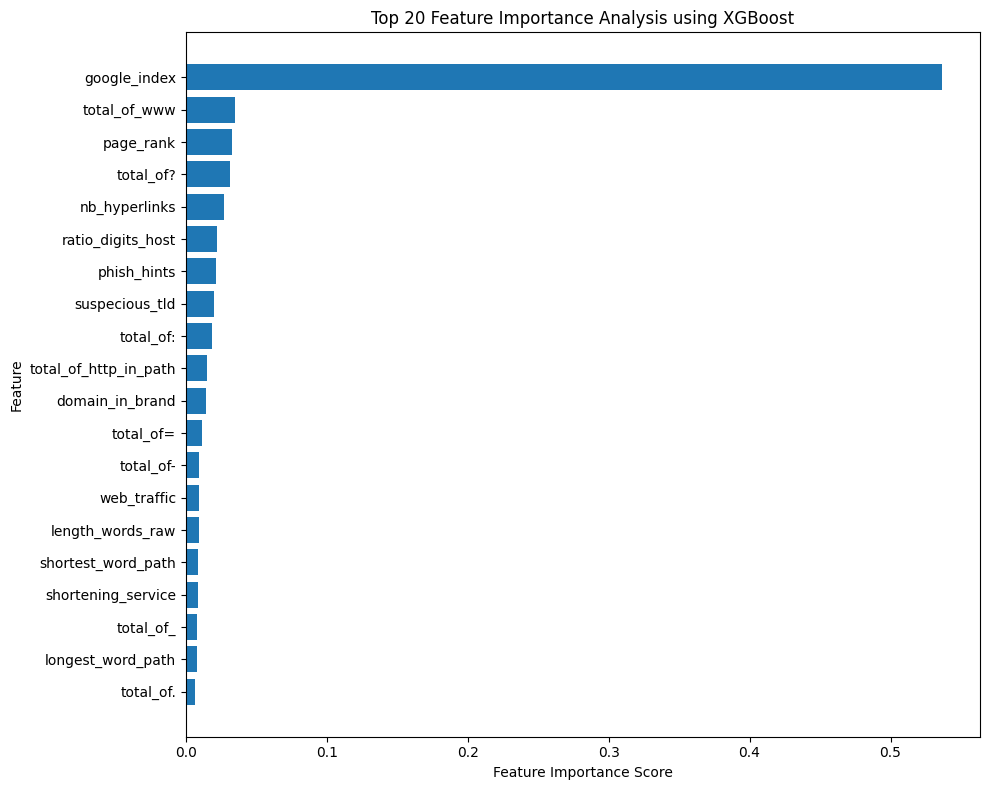

In [ ]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path)
X_train = phishing_data.drop(columns=['status', 'url'])  # Ensure 'status' is not included
y_train = phishing_data['status'].map({'legitimate': 0, 'phishing': 1})

# Convert all features to numeric, coercing errors for any non-numeric data
X_train = X_train.apply(pd.to_numeric, errors='coerce')
print("NaNs per column after coercion:", X_train.isna().sum())

# Fill NaN values
X_train.fillna(X_train.mean(), inplace=True)

# Drop columns with zero variance
variances = X_train.var()
columns_dropped = variances[variances == 0].index
X_train = X_train.loc[:, variances != 0]
print(f"Columns dropped (zero variance): {list(columns_dropped)}")
print(f"Remaining features: {X_train.shape[1]}")

# Define and train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Get and sort feature importance
feature_importance = model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_names = X_train.columns[sorted_indices]
top_n = 20
top_sorted_feature_names = sorted_feature_names[:top_n]
top_feature_importance = feature_importance[sorted_indices][:top_n]

print("Top feature importances:", list(zip(top_sorted_feature_names, top_feature_importance)))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_sorted_feature_names[::-1], top_feature_importance[::-1])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance Analysis using XGBoost')
plt.tight_layout()
plt.show()


**Random** **Forest Classifier (for feature importance)**

<ipython-input-33-ef6df5ece830>:8: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  phishing_data = pd.read_csv(file_path)


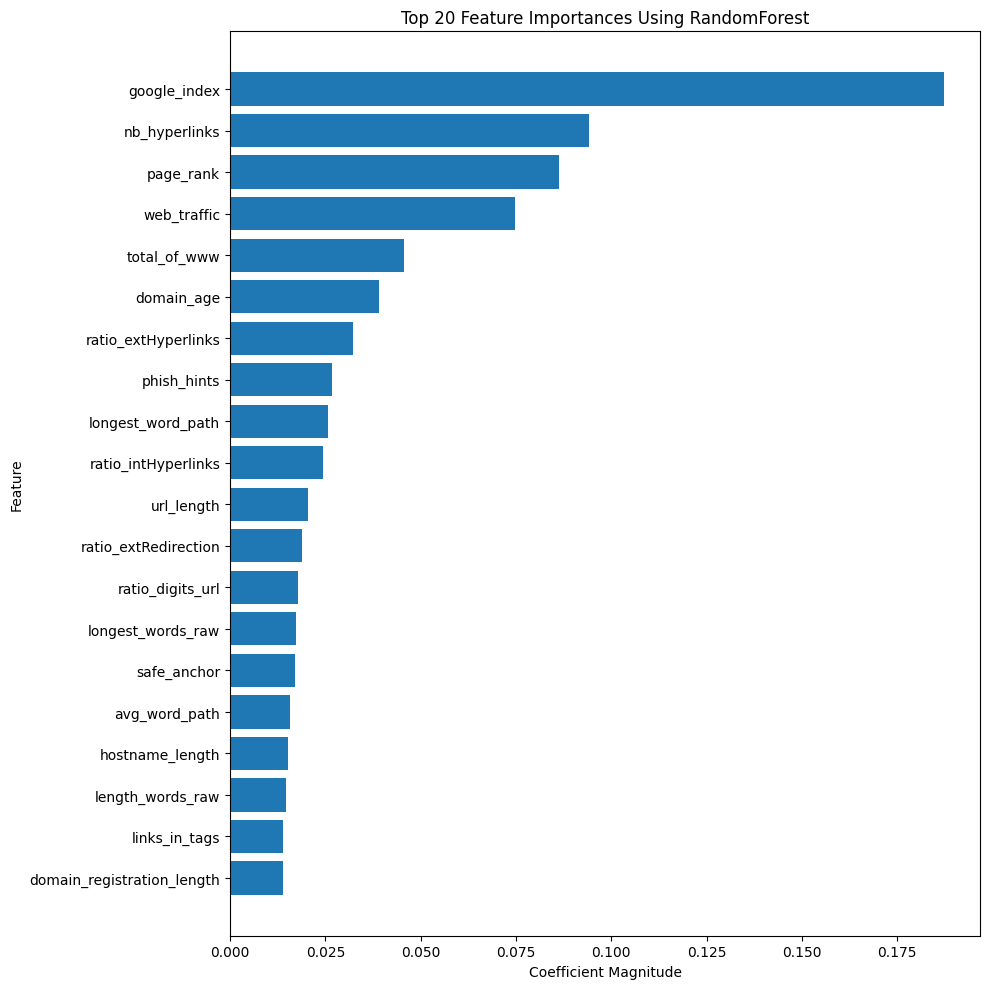

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Load the dataset
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path)

# Handle potential mixed-type issues
phishing_data.iloc[:, 78] = pd.to_numeric(phishing_data.iloc[:, 78], errors='coerce')

# Convert the 'status' column into a binary format where 'phishing' is 1 and 'legitimate' is 0
phishing_data['status'] = phishing_data['status'].map({'phishing': 1, 'legitimate': 0})

# Drop any remaining missing values to clean up the dataset
phishing_data_clean = phishing_data.dropna()

# Separate features and the target variable
y_train = phishing_data_clean['status']
X_train = phishing_data_clean.drop(columns=['status', 'url'])  # Exclude the non-numeric and target column

# Initialize and train the RandomForest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Extract feature names
feature_names = X_train.columns

# Get the feature importances, sort them, and create a bar chart
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_feature_names = feature_names[indices]
top_features = sorted_feature_names[:20]  # Select the top 20 features
top_importances = importances[indices][:20]

plt.figure(figsize=(10, 10))
plt.barh(top_features[::-1], top_importances[::-1])  # Reverse the order to have the most important at the top
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances Using RandomForest')
plt.tight_layout()
plt.show()




```
# Checking RMSE and MAE
```



**Correlation Analysis for variables**

```
# Correlation Analysis
```



In [ ]:
feature_importances = X_train.columns
top_n=20
top_feature_importances = feature_importances[sorted_indices][:top_n]

In [ ]:
# Sort feature importances and get the sorted feature names
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [f'Feature {i}' for i in sorted_indices]

# Determine the number of features to display
n_features_to_display = 20  # Adjust this to display more or fewer features

# Increase the figure size for better readability
plt.figure(figsize=(20, 20))  # Width, Height in inches



<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [ ]:
print(f"Length of top_feature_importances: {len(top_feature_importances)}")
print(f"Length of sorted_feature_names: {len(sorted_feature_names)}")

Length of top_feature_importances: 20
Length of sorted_feature_names: 85


In [ ]:
if n_features_to_display > len(top_feature_importances) or n_features_to_display > len(sorted_feature_names):
    raise ValueError("n_features_to_display should not exceed the lengths of top_feature_importances and sorted_feature_names.")


In [ ]:
print("Shape of feature_importances:", feature_importances.shape)
print("Shape of sorted_feature_names:", len(sorted_feature_names))
print("Shape of sorted_indices:", sorted_indices.shape)

Shape of feature_importances: (85,)
Shape of sorted_feature_names: 85
Shape of sorted_indices: (85,)


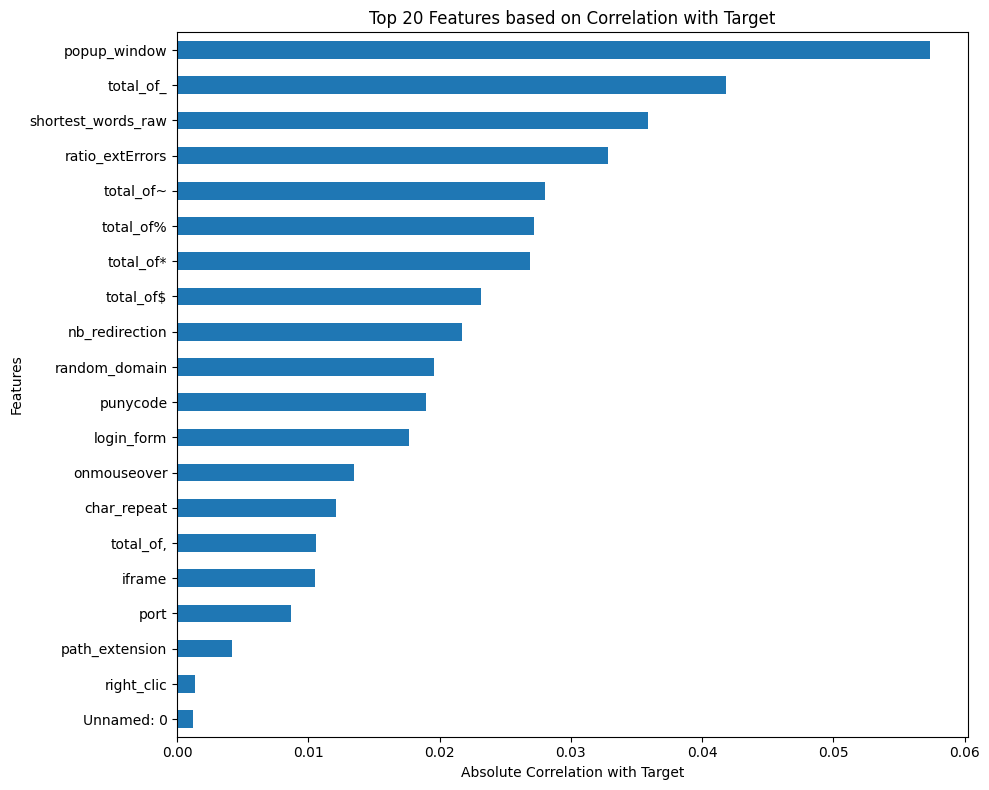

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path, low_memory=False)

# Handle mixed-type issues by converting them to numeric, errors are coerced to NaN
phishing_data.iloc[:, 78] = pd.to_numeric(phishing_data.iloc[:, 78], errors='coerce')

# Convert categorical 'status' column into numeric
phishing_data['status'] = phishing_data['status'].map({'phishing': 1, 'legitimate': 0})

# Drop columns that won't be used as features (if any)
phishing_data.drop(columns=['url'], inplace=True)  # Assuming 'url' is not a feature

# Encode categorical data
for col in phishing_data.select_dtypes(include=['object']).columns:
    phishing_data[col] = LabelEncoder().fit_transform(phishing_data[col].astype(str))

# Impute missing values
imputer = SimpleImputer(strategy='mean')
phishing_data = pd.DataFrame(imputer.fit_transform(phishing_data), columns=phishing_data.columns)

# Calculate the correlation matrix
corr_matrix = phishing_data.corr()

# Extract correlation with the target variable 'status'
target_corr = corr_matrix['status'].drop('status')  # Remove self-correlation

# Sort the values based on the magnitude (absolute value)
sorted_corr = target_corr.abs().sort_values(ascending=True)

# Plot the correlations as a bar chart for the top 20 features
plt.figure(figsize=(10, 8))
sorted_corr[:20].plot(kind='barh')  # Limit to top 20 and use barh for horizontal bar chart
plt.title('Top 20 Features based on Correlation with Target')
plt.xlabel('Absolute Correlation with Target')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Logistic Regression


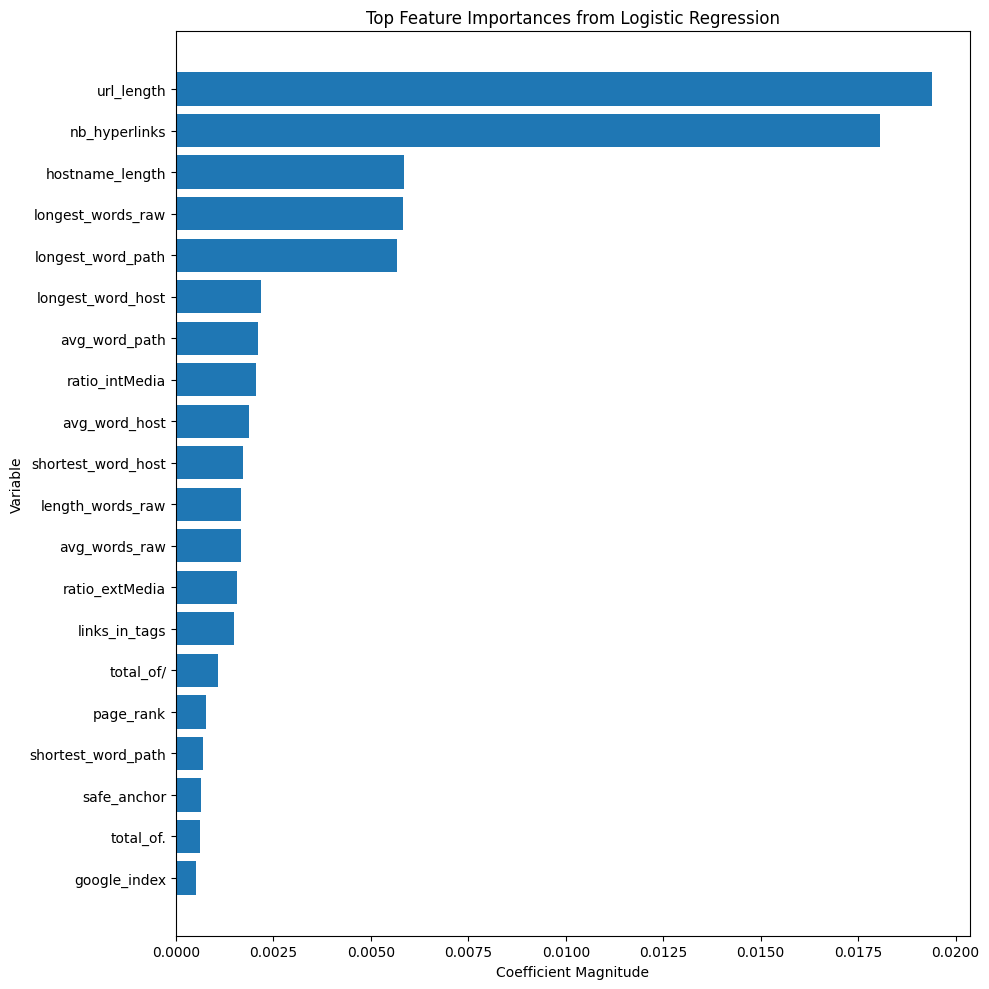

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path, low_memory=False)

#Status variable
y_train = phishing_data['status'].map({'legitimate': 0, 'phishing': 1})

#Dropping unnecessary Columns
X = phishing_data.drop(columns=['status', 'url'])  # Drop non-feature columns
X = X.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)) if col.dtype == 'object' else col)

# Fill NaN values with the mean of each column
X.fillna(X.mean(), inplace=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Extract the absolute values of the coefficients
feature_importances = np.abs(clf.coef_[0])
feature_names = X_train.columns

# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)
num_features = len(feature_importances)
top_n = min(20, num_features)  # Choose the top n features

# Get the names and importance values of the top features
sorted_feature_names = np.array(feature_names)[sorted_idx][-top_n:]
sorted_importances = feature_importances[sorted_idx][-top_n:]

plt.figure(figsize=(10, 10))

# Create horizontal bar plot
plt.barh(sorted_feature_names, sorted_importances)

# Set labels and title
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Variable')
plt.title('Top Feature Importances from Logistic Regression')

# Improve layout
plt.tight_layout()

plt.show()


In [ ]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=70be525c13b206b4f214128db225377e64f721f402ef6c4f1e0736faede102aa
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
perm = PermutationImportance(clf, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.1780 ± 0.0091,nb_hyperlinks
0.0427 ± 0.0050,domain_age
0.0371 ± 0.0047,url_length
0.0035 ± 0.0012,hostname_length
0.0025 ± 0.0009,longest_word_path
0.0025 ± 0.0015,longest_words_raw
0.0014 ± 0.0022,domain_registration_length
0.0013 ± 0.0006,web_traffic
0.0010 ± 0.0012,ratio_extMedia
0.0005 ± 0.0005,shortest_word_host


# Machine Learning Modeling

**Random Forest Prediction**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
ph.columns

Index(['Unnamed: 0', 'url', 'url_length', 'hostname_length', 'ip', 'total_of.',
       'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
       'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*',
       'total_of:', 'total_of,', 'total_of;', 'total_of$', 'total_of_www',
       'total_of_com', 'total_of_http_in_path', 'https_token',
       'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port',
       'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain',
       'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statist

In [ ]:
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path, low_memory=False)
y_train = phishing_data['status'].map({'legitimate': 0, 'phishing': 1})
#Features selected from feature importance models
phFeatures = ['google_index', 'web_traffic', 'nb_hyperlinks', 'domain_age', 'url_length', 'popup_window', 'page_rank']
X = phishing_data[phFeatures]

X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.2, random_state=42)

In [ ]:
rf_mod = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
rf_mod.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_mod.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.9861075379470028


In [ ]:
print(y_pred)

[0 0 1 ... 0 0 0]


In [ ]:
unique_classes, class_counts = np.unique(y_pred, return_counts=True)

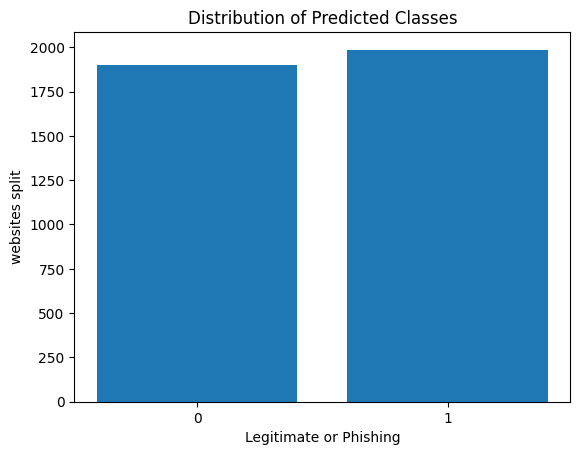

In [ ]:
# Create a bar plot
plt.bar(unique_classes, class_counts)
plt.xlabel('Legitimate or Phishing')
plt.ylabel('websites split')
plt.title('Distribution of Predicted Classes')
plt.xticks(unique_classes)  # Ensure all classes are displayed on x-axis
plt.show()

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 0.11786628887428827
Mean Absolute Error (MAE): 0.01389246205299717


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9861
Precision: 0.9829
Recall: 0.9899
F1 Score: 0.9864
Confusion Matrix:
[[1881   34]
 [  20 1952]]


In [ ]:
#Loading Secondary file for Minor
nph = '/content/clean_newphishingdata.csv'
npd = pd.read_csv(nph, low_memory=False)

npd['status'] = npd['status'].map({'legitimate': 0, 'phishing': 1})


In [ ]:
# Select the same features used in the original model
X_secondary = npd[phFeatures]

y_test = y_test

# Use random forest to make predictions on the new data
sec_pred = rf_mod.predict(X_secondary)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#Phishing or Legitimate status to compare against prediction
y_true = npd['status']

# Calculating Metrics
accuracy = accuracy_score(y_true, sec_pred)
precision = precision_score(y_true, sec_pred, pos_label=1)
recall = recall_score(y_true, sec_pred)
f1 = f1_score(y_true, sec_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, sec_pred))

Accuracy: 0.9979966901837819
Precision: 0.9975635224504003
Recall: 0.9984323288625675
F1 Score: 0.9979977365717767
Confusion Matrix:
[[5726   14]
 [   9 5732]]


In [ ]:
##Calculating RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_true, sec_pred))

mae = mean_absolute_error(y_true, sec_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 0.04475834912301949
Mean Absolute Error (MAE): 0.0020033098162180996




```
User Interaction
```



In [ ]:
pip install pandas scikit-learn matplotlib requests beautifulsoup4 tld whois


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 5.4 MB/s eta 0:00:00


Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


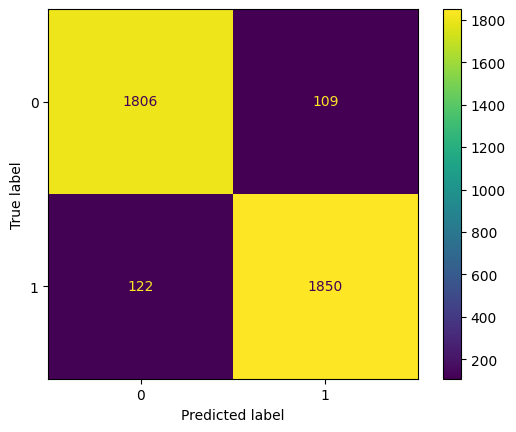

KeyboardInterrupt: Interrupted by user

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import re
import matplotlib.pyplot as plt

def normalize_url(url):
    """Normalize the URL to ensure it includes the HTTP/HTTPS prefix."""
    if not url.startswith(("http://", "https://")):
        url = "https://" + url
    return url

def extract_features(url):
    """Extract various features from the URL to use in the model, including parsing for specific characteristics."""
    url = normalize_url(url)
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path

    # Initialize dictionary to hold feature values, including new checks
    features = {
        'url_length': len(url),  # Total length of the URL
        'hostname_length': len(domain),  # Length of the hostname
        'https_token': 1 if parsed_url.scheme == 'https' else 0,  # Binary feature for HTTPS
        'nb_subdomains': domain.count('.') if '.' in domain else 0,  # Count subdomains
        'prefix_suffix': 1 if '-' in domain else 0,  # Detect '-' as a feature of phishing
        'tld_in_path': 1 if any(tld in path for tld in ['.com', '.net', '.org']) else 0,  # Check TLD presence in path
        'tld_in_subdomain': 1 if any(tld in domain.split('.')[0] for tld in ['.com', '.net', '.org']) else 0,  # Check TLD in subdomain
        'path_extension': 1 if re.search(r'\.(php|html|asp)$', path) else 0,  # Check for web file extensions
        'random_domain': 1 if re.search(r'\d{3,}', domain) else 0,  # Check for numerical sequences in domain
        'shortening_service': 1 if 'bit.ly' in domain or 'goo.gl' in domain else 0  # Check for URL shortening services
    }

    # Adding counts of specific characters which might indicate suspicious URLs
    special_chars = ['-','@','?','&','=','_','~','%','/','*',';',':',',','$','.']
    for char in special_chars:
        features[f'total_of{char}'] = url.count(char)

    # Check for 'www.' as part of the subdomain
    features['total_of_www'] = 1 if 'www.' in domain else 0

    # Attempt to parse the HTML content to find popup scripts
    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.content, 'html.parser')
        scripts = soup.find_all('script')
        features['popup_window'] = 1 if any("window.open" in script.text for script in scripts) else 0
    except requests.RequestException:
        features['popup_window'] = 0

    return features

def get_user_feedback(url, prediction):
    """Ask the user for feedback on the model's prediction."""
    print(f"The URL '{url}' is classified as {'Phishing' if prediction == 1 else 'Legitimate'}. Do you agree? (yes/no)")
    feedback = input().strip().lower()
    return feedback == 'yes'

def main():
    """Main function to train the model, evaluate it, and use it for predictions with user feedback."""
    file_path = '/content/dataset_link_phishing.csv'
    phishing_data = pd.read_csv(file_path, low_memory=False)

    # List of features used in the model based on the data dictionary
    feature_columns = [
        'url_length', 'hostname_length', 'https_token', 'nb_subdomains', 'prefix_suffix',
        'tld_in_path', 'tld_in_subdomain', 'path_extension', 'random_domain', 'shortening_service',
        'popup_window', 'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
        'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*', 'total_of:',
        'total_of,', 'total_of;', 'total_of$', 'total_of.', 'total_of_www'
    ]

    X = phishing_data[feature_columns]
    y = phishing_data['status'].map({'legitimate': 0, 'phishing': 1})
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate model performance using standard metrics
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

    # Plotting the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # User input for real-time classification and feedback collection
    user_url = input("Enter a URL to classify: ")
    user_features = extract_features(user_url)
    user_features_df = pd.DataFrame([user_features], columns=feature_columns)

    user_prediction = model.predict(user_features_df)[0]
    feedback_correct = get_user_feedback(user_url, user_prediction)
    if feedback_correct:
        print("Thank you for your feedback! We're glad the prediction was correct.")
    else:
        print("Thank you for your feedback! We will use it to improve our model.")
    # Note: The feedback from the user does not dynamically alter the RandomForest model's training during this interaction.
    # RandomForest does not inherently update or learn from new data points (like user feedback) within this session.
    # It remains static after its initial training and does not integrate feedback without retraining.


if __name__ == "__main__":
    main()


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import re
import matplotlib.pyplot as plt

def normalize_url(url):
    if not url.startswith(("http://", "https://")):
        url = "https://" + url
    return url

def extract_features(url):
    url = normalize_url(url)
    parsed_url = urlparse(url)
    domain = parsed_url.netloc or 'example.com'
    path = parsed_url.path

    features = {
        'url_length': len(url),
        'hostname_length': len(domain),
        'https_token': 1 if parsed_url.scheme == 'https' else 0,
        'nb_subdomains': domain.count('.'),
        'prefix_suffix': 1 if '-' in domain else 0,
        'tld_in_path': 1 if any(tld in path for tld in ['.com', '.net', '.org']) else 0,
        'tld_in_subdomain': 1 if any(tld in domain.split('.')[-1] for tld in ['com', 'net', 'org']) else 0,
        'path_extension': 1 if re.search(r'\.(php|html|asp)$', path) else 0,
        'random_domain': 1 if re.search(r'\d', domain) else 0,
        'shortening_service': 1 if 'bit.ly' in domain or 'goo.gl' in domain else 0,
        'popup_window': 0
    }
    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.content, 'html.parser')
        features['popup_window'] = 1 if any("window.open" in script.text for script in soup.find_all('script')) else 0
    except requests.RequestException:
        features['popup_window'] = 0
    return features

def get_user_feedback(url, prediction):
    response = input(f"The URL '{url}' is classified as {'Phishing' if prediction else 'Legitimate'}. Do you agree? (yes/no): ")
    return response.strip().lower() == 'yes'

def main():
    file_path = '/content/dataset_link_phishing.csv'
    phishing_data = pd.read_csv(file_path, low_memory=False)
    feature_columns = [
        'url_length', 'hostname_length', 'https_token', 'nb_subdomains', 'prefix_suffix',
        'tld_in_path', 'tld_in_subdomain', 'path_extension', 'random_domain', 'shortening_service',
        'popup_window', 'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
        'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*', 'total_of:',
        'total_of,', 'total_of;', 'total_of$', 'total_of.', 'total_of_www'
    ]
    X = phishing_data[feature_columns]
    y = phishing_data['status'].map({'legitimate': 0, 'phishing': 1})
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Use SimpleImputer to maintain DataFrame structure
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=feature_columns)

    # Initialize and partially fit the SGDClassifier with DataFrame to ensure feature names
    model = SGDClassifier(loss='log_loss', random_state=42)
    model.partial_fit(X_train, y_train, classes=np.array([0, 1]))

    while True:
        user_url = input("Enter a URL to classify or 'exit' to quit: ")
        if user_url.lower() == 'exit':
            break
        user_features = extract_features(user_url)
        user_features_df = pd.DataFrame([user_features], columns=feature_columns)
        user_features_df = pd.DataFrame(imputer.transform(user_features_df), columns=feature_columns)

        user_prediction = model.predict(user_features_df)[0]
        feedback_correct = get_user_feedback(user_url, user_prediction)

        if feedback_correct:
            print("Thank you for your feedback! We're glad the prediction was correct.")
        else:
            correct_label = 0 if user_prediction else 1
            model.partial_fit(user_features_df, np.array([correct_label]))
            print("Thank you for your feedback! We will use it to improve our model.")

    y_pred = model.predict(X_test)
    print(f"Updated Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

if __name__ == "__main__":
    main()


KeyboardInterrupt: Interrupted by user

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import re
import matplotlib.pyplot as plt

def normalize_url(url):
    if not url.startswith(("http://", "https://")):
        url = "https://" + url
    return url

def extract_features(url):
    url = normalize_url(url)
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path

    features = {
        'url_length': len(url),
        'hostname_length': len(domain),
        'https_token': 1 if parsed_url.scheme == 'https' else 0,
        'nb_subdomains': domain.count('.') if '.' in domain else 0,
        'prefix_suffix': 1 if '-' in domain else 0,
        'tld_in_path': 1 if any(tld in path for tld in ['.com', '.net', '.org']) else 0,
        'tld_in_subdomain': 1 if any(tld in domain.split('.')[0] for tld in ['.com', '.net', '.org']) else 0,
        'path_extension': 1 if re.search(r'\.(php|html|asp)$', path) else 0,
        'random_domain': 1 if re.search(r'\d{3,}', domain) else 0,
        'shortening_service': 1 if 'bit.ly' in domain or 'goo.gl' in domain else 0,
        'popup_window': 0
    }

    special_chars = ['-', '@', '?', '&', '=', '_', '~', '%', '/', '*', ';', ':', ',', '$', '.']
    for char in special_chars:
        features[f'total_of{char}'] = url.count(char)

    features['total_of_www'] = 1 if 'www.' in domain else 0

    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.content, 'html.parser')
        features['popup_window'] = 1 if any("window.open" in script.text for script in soup.find_all('script')) else 0
    except requests.RequestException:
        features['popup_window'] = 0

    return features

def get_user_feedback(url, prediction):
    response = input(f"The URL '{url}' is classified as {'Phishing' if prediction else 'Legitimate'} by RandomForest. Do you agree? (yes/no): ")
    return response.strip().lower() == 'yes'

def main():
    file_path = '/content/dataset_link_phishing.csv'
    phishing_data = pd.read_csv(file_path, low_memory=False)
    feature_columns = [
        'url_length', 'hostname_length', 'https_token', 'nb_subdomains', 'prefix_suffix',
        'tld_in_path', 'tld_in_subdomain', 'path_extension', 'random_domain', 'shortening_service',
        'popup_window', 'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
        'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*', 'total_of:',
        'total_of,', 'total_of;', 'total_of$', 'total_of.', 'total_of_www'
    ]
    X = phishing_data[feature_columns]
    y = phishing_data['status'].map({'legitimate': 0, 'phishing': 1})

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    primary_model = RandomForestClassifier(n_estimators=100, random_state=42)
    primary_model.fit(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    feedback_model = SGDClassifier(loss='log_loss', random_state=42)
    feedback_model.partial_fit(X_train_scaled, y_train, classes=np.array([0, 1]))

    uncertainty_threshold = 0.7  # Define a threshold for uncertainty, correctly positioned now

    session_predictions = []
    session_true_labels = []

    while True:
        user_url = input("Enter a URL to classify or 'exit' to quit: ")
        if user_url.lower() == 'exit':
            break

        user_features = extract_features(user_url)
        user_features_df = pd.DataFrame([user_features], columns=feature_columns)
        user_features_scaled = scaler.transform(user_features_df)

        primary_proba = primary_model.predict_proba(user_features_df)[0]
        primary_prediction = np.argmax(primary_proba)

        if max(primary_proba) < uncertainty_threshold:
            secondary_prediction = feedback_model.predict(user_features_scaled)[0]
            print("Primary model uncertain, using SGDClassifier.")
            prediction_used = secondary_prediction
        else:
            prediction_used = primary_prediction

        feedback_correct = get_user_feedback(user_url, prediction_used)
        correct_label = prediction_used if feedback_correct else 1 - prediction_used
        session_predictions.append(prediction_used)
        session_true_labels.append(correct_label)

        if not feedback_correct:
            feedback_model.partial_fit(user_features_scaled, [correct_label])
            print("Feedback has been used to improve the SGDClassifier.")

    print("Base Model Accuracy:")
    y_pred = primary_model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    if session_predictions:
        session_accuracy = accuracy_score(session_true_labels, session_predictions)
        print("Accuracy during this run:")
        print(f"Accuracy: {session_accuracy:.2f}")
    else:
        print("No user inputs were provided to evaluate session-based accuracy.")

if __name__ == "__main__":
    main()



Enter a URL to classify or 'exit' to quit: www.google.com
The URL 'www.google.com' is classified as Legitimate by RandomForest. Do you agree? (yes/no): yes
Enter a URL to classify or 'exit' to quit: www.providence.com
The URL 'www.providence.com' is classified as Legitimate by RandomForest. Do you agree? (yes/no): yes
Enter a URL to classify or 'exit' to quit: www.providence.edu
The URL 'www.providence.edu' is classified as Legitimate by RandomForest. Do you agree? (yes/no): www.instagram.com
Feedback has been used to improve the SGDClassifier.
Enter a URL to classify or 'exit' to quit: www.instagram.com
The URL 'www.instagram.com' is classified as Legitimate by RandomForest. Do you agree? (yes/no): yes
Enter a URL to classify or 'exit' to quit: http://signin.eday.co.uk.ws.edayisapi.dllsign.inusingsslpuseridcopartnerid2siteid.zdfxx949xyss1pnbh0soabfdzgdh2kppnu.reippl.com/
The URL 'http://signin.eday.co.uk.ws.edayisapi.dllsign.inusingsslpuseridcopartnerid2siteid.zdfxx949xyss1pnbh0soabfd